In [11]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf
import sklearn.metrics as metrics

import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

#from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/jb_py35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [13]:
os.getcwd()

'/home/jbang36/eva/others/jupyter'

In [14]:
# Set the dataset paths
root_dir = os.path.abspath('../')
data_dir = os.path.join(root_dir, 'data', 'mnist')
root_dir
data_dir

'/home/jbang36/eva/others/data/mnist'

In [15]:
# Load MNIST dataset
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()


8


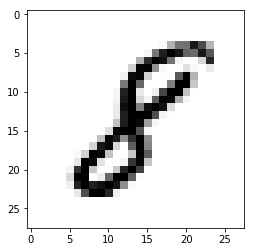

In [16]:
# Print an image from the dataset
import matplotlib.pyplot as plt
image_index = 7777 # You may select anything up to 60,000
print(train_y[image_index]) # The label is 8
plt.imshow(train_x[image_index], cmap='Greys')

In [7]:
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20)

In [17]:
# Reshape and normalize
train_x = train_x.reshape(-1, 784).astype('float32')
test_x = test_x.reshape(-1, 784).astype('float32')
train_x /= 255.0
test_x /= 255.0


In [9]:
# Apply Kmeans clustering
import time
start_time = time.time()
km.fit(train_x)
print("Total time it took to train k_means is ", time.time() - start_time, " seconds")

Total time it took to train k_means is  150.07240200042725  seconds


In [10]:
pred = km.predict(test_x)

In [13]:
# Calculate MI Score between the actual labels and the ones predicted by the clustering
kmeans_score = normalized_mutual_info_score(test_y, pred)

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [18]:
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              22000     
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1000500   
__________

In [20]:
encoder = Model(input_img, encoded)

In [21]:
autoencoder.compile(optimizer='adam', loss='mse')

In [22]:
# Train the autoencoder
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 53us/step - loss: 0.0737 - val_loss: 0.0647
Epoch 2/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0639 - val_loss: 0.0635
Epoch 3/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0629 - val_loss: 0.0597
Epoch 4/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0556 - val_loss: 0.0514
Epoch 5/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0485 - val_loss: 0.0444
Epoch 6/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.0425 - val_loss: 0.0399
Epoch 7/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0378 - val_loss: 0.0354
Epoch 8/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0339 - val_loss: 0.0318
Epoch 9/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.0310 - val_loss: 0.0

In [23]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(test_x)

Time to fit  60000 :  186.00084447860718
0
9


Text(0, 0.5, 'Number of datapoints')

/nethome/jbang36/anaconda3/envs/jb_py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


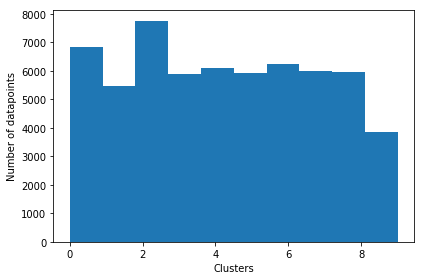

In [28]:
# Hierarchical Clustering

from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=10)

start_time = time.time()
ac.fit(pred_auto_train)
n_samples = pred_auto_train.shape[0]
print("Time to fit ", n_samples, ": ", time.time() - start_time)
images_label = ac.labels_

print(min(images_label))
print(max(images_label))

# I think it is best to see the distributions

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(images_label, bins=10)
plt.xlabel("Clusters")
plt.ylabel("Number of datapoints")

In [22]:
# KMeans 
km_auto = KMeans(n_jobs=-1, n_clusters=10, n_init=20)
start_time = time.time()
km_auto.fit(pred_auto_train)
print("Total time it took to train k_means is ", time.time() - start_time, " seconds")

pred = km_auto.predict(pred_auto)
auto_score = normalized_mutual_info_score(test_y, pred)
auto_score

In [14]:
# Density clustering

import numpy as numpy
import scipy as scipy
from sklearn import cluster
import matplotlib.pyplot as plt

# Util functions
def set2List(NumpyArray):
    list = []
    for item in NumpyArray:
        list.append(item.tolist())
    return list
 
def GenerateData():
    x1=numpy.random.randn(50,2)
    x2x=numpy.random.randn(80,1)+12
    x2y=numpy.random.randn(80,1)
    x2=numpy.column_stack((x2x,x2y))
    x3=numpy.random.randn(100,2)+8
    x4=numpy.random.randn(120,2)+15
    z=numpy.concatenate((x1,x2,x3,x4))
    return z

#DBSCAN functions
def DBSCAN(Dataset, Epsilon,MinumumPoints,DistanceMethod = 'euclidean'):
    """
    :param Dataset: an mxn matrix representing the data containg m items and n is dimension of data
    :param Epsilon: A threshold value for being a neighbour
    :param MinumumPoints: Minimum neighbours a point should have
    :param DistanceMethod: Method to calculate the distance
    :return: The point cluster numbers
    """   
    m,n=Dataset.shape
    Visited=numpy.zeros(m,'int')
    Type=numpy.zeros(m)
#   -1 noise, outlier
#    0 border
#    1 core
    ClustersList=[]
    Cluster=[]
    PointClusterNumber=numpy.zeros(m)
    PointClusterNumberIndex=1
    PointNeighbors=[]
    DistanceMatrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Dataset, DistanceMethod))
    for i in range(m):
        if Visited[i]==0:
            Visited[i]=1
            PointNeighbors=numpy.where(DistanceMatrix[i]<Epsilon)[0]
            if len(PointNeighbors)<MinumumPoints:
                Type[i]=-1
            else:
                for k in range(len(Cluster)):
                    Cluster.pop()
                Cluster.append(i)
                PointClusterNumber[i]=PointClusterNumberIndex
                
                
                PointNeighbors=set2List(PointNeighbors)    
                ExpandClsuter(Dataset[i], PointNeighbors,Cluster,MinumumPoints,Epsilon,Visited,DistanceMatrix,PointClusterNumber,PointClusterNumberIndex  )
                Cluster.append(PointNeighbors[:])
                ClustersList.append(Cluster[:])
                PointClusterNumberIndex=PointClusterNumberIndex+1
                 
                    
    return PointClusterNumber 
 
 
 
def ExpandClsuter(PointToExapnd, PointNeighbors,Cluster,MinumumPoints,Epsilon,Visited,DistanceMatrix,PointClusterNumber,PointClusterNumberIndex  ):
    """
    :param PointToExapnd: The point to expand
    :param PointNeighbors: Neighbours of the point
    :param Cluster: The cluster
    :param MinumumPoints: Minimum neighbours a point should have
    :param Epsilon: A threshold value for being a neighbour
    :param Visited: To check if neighbour is visited already
    :param DistanceMatrix: Distances between the points
    :param PointClusterNumber: The cluster the point belongs to
    :param PointClusterNumberIndex: Index of the cluster number
    :return: The point cluster numbers
    """   
    Neighbors=[]
 
    for i in PointNeighbors:
        if Visited[i]==0:
            Visited[i]=1
            Neighbors=numpy.where(DistanceMatrix[i]<Epsilon)[0]
            if len(Neighbors)>=MinumumPoints:
#                Neighbors merge with PointNeighbors
                for j in Neighbors:
                    try:
                        PointNeighbors.index(j)
                    except ValueError:
                        PointNeighbors.append(j)
                    
        if PointClusterNumber[i]==0:
            Cluster.append(i)
            PointClusterNumber[i]=PointClusterNumberIndex
    return
 

In [18]:
print(pred_auto_train.shape)

(60000, 10)


In [35]:
# Density Clustering Parameters

Epsilon = 1 #euclidean distance
MinumumPoints = 500
Data = pred_auto
start_time = time.time()
result =DBSCAN(Data,Epsilon,MinumumPoints)
print("Total time it took to for density clustering evaluation is ", time.time() - start_time, " seconds")

max_result = max(result)
print(max_result)
for i in range(max_result):    
    print(sum(result == i))
print(sum(result == max_result))
auto_score = normalized_mutual_info_score(test_y, result)
auto_score

KeyboardInterrupt: 

In [26]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.accuracy_score(self.y, y_pred), metrics.normalized_mutual_info_score(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time.time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time.time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time.time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
                    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
                    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred


# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 2e4
tol = 0.0001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 500
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

dec.pretrain(x=train_x, y=train_y, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/500
60000/60000 [==============================] - 3s 50us/step - loss: 0.0861
        |==>  acc: 0.0935,  nmi: 0.0989  <==|
Epoch 2/500
 4096/60000 [=>............................] - ETA: 1s - loss: 0.0653

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0642
Epoch 3/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0635
Epoch 4/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0633
Epoch 5/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0625
Epoch 6/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0567
Epoch 7/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0534
Epoch 8/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0482
Epoch 9/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0415
Epoch 10/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0355
Epoch 11/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0315
Epoch 12/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0293
Epoch 13/500
60000/60000 [==========================

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0142
Epoch 53/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0141
Epoch 54/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0140
Epoch 55/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0139
Epoch 56/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0139
Epoch 57/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0138
Epoch 58/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0138
Epoch 59/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0137
Epoch 60/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0137
Epoch 61/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0135
Epoch 62/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0136
Epoch 63/500
60000/60000 [===================

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0118
Epoch 103/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0119
Epoch 104/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0118
Epoch 105/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0119
Epoch 106/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0118
Epoch 107/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0117
Epoch 108/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0117
Epoch 109/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0117
Epoch 110/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0116
Epoch 111/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0116
Epoch 112/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0116
Epoch 113/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0107
Epoch 153/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0108
Epoch 154/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0107
Epoch 155/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0107
Epoch 156/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0107
Epoch 157/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0107
Epoch 158/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0106
Epoch 159/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.0107
Epoch 160/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0106
Epoch 161/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0106
Epoch 162/500
60000/60000 [==============================] - 2s 26us/step - loss: 0.0106
Epoch 163/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 2s 27us/step - loss: 0.0100
Epoch 203/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0100
Epoch 204/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0100
Epoch 205/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0101
Epoch 206/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0100
Epoch 207/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0100
Epoch 208/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0100
Epoch 209/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.0099
Epoch 210/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0100
Epoch 211/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0099
Epoch 212/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0099
Epoch 213/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0095
Epoch 253/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0095
Epoch 254/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0095
Epoch 255/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.0096
Epoch 256/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0095
Epoch 257/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0095
Epoch 258/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0094
Epoch 259/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0095
Epoch 260/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0095
Epoch 261/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0094
Epoch 262/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0094
Epoch 263/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0092
Epoch 303/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0092
Epoch 304/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 305/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 306/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.0092
Epoch 307/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 308/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0091
Epoch 309/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0092
Epoch 310/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 311/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 312/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0091
Epoch 313/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0089
Epoch 353/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0089
Epoch 354/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0088
Epoch 355/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0089
Epoch 356/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0088
Epoch 357/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0089
Epoch 358/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0089
Epoch 359/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0088
Epoch 360/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0088
Epoch 361/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0088
Epoch 362/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0088
Epoch 363/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 2s 26us/step - loss: 0.0086
Epoch 403/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0086
Epoch 404/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0087
Epoch 405/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0087
Epoch 406/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0087
Epoch 407/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0086
Epoch 408/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0086
Epoch 409/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0086
Epoch 410/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0086
Epoch 411/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0086
Epoch 412/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0087
Epoch 413/500
60000/60000 [========

/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


60000/60000 [==============================] - 1s 25us/step - loss: 0.0085
Epoch 453/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0084
Epoch 454/500
60000/60000 [==============================] - 1s 25us/step - loss: 0.0084
Epoch 455/500
60000/60000 [==============================] - 1s 24us/step - loss: 0.0085
Epoch 456/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0085
Epoch 457/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 458/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 459/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 460/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 461/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 462/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.0084
Epoch 463/500
60000/60000 [========

In [27]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110
Trainable params: 1,665,110
Non-trainable params: 0
_________________________________________________________________


In [28]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [29]:
y_pred = dec.fit(train_x, y=train_y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 200
Save interval 146.484375
Initializing cluster centers with k-means.


/nethome/jbang36/miniconda2/envs/pp36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.05088, nmi = 0.77332, ari = 0.72686  ; loss= 0
saving model to: results/DEC_model_0.h5
Iter 200: acc = 0.05050, nmi = 0.77894, ari = 0.73977  ; loss= 0
Iter 400: acc = 0.05045, nmi = 0.79176, ari = 0.75790  ; loss= 0
Iter 600: acc = 0.04940, nmi = 0.80387, ari = 0.77173  ; loss= 0
Iter 800: acc = 0.04915, nmi = 0.81126, ari = 0.77959  ; loss= 0
Iter 1000: acc = 0.04907, nmi = 0.81544, ari = 0.78393  ; loss= 0
Iter 1200: acc = 0.04887, nmi = 0.81856, ari = 0.78698  ; loss= 0
Iter 1400: acc = 0.04897, nmi = 0.82119, ari = 0.78957  ; loss= 0
Iter 1600: acc = 0.04893, nmi = 0.82321, ari = 0.79143  ; loss= 0
Iter 1800: acc = 0.04865, nmi = 0.82513, ari = 0.79332  ; loss= 0
Iter 2000: acc = 0.04868, nmi = 0.82601, ari = 0.79421  ; loss= 0
Iter 2200: acc = 0.04862, nmi = 0.82645, ari = 0.79450  ; loss= 0
Iter 2400: acc = 0.04857, nmi = 0.82719, ari = 0.79518  ; loss= 0
Iter 2600: acc = 0.04857, nmi = 0.82789, ari = 0.79591  ; loss= 0
Iter 2800: acc = 0.04865, nmi = 0.82805, ar

In [30]:
pred_val = dec.predict(test_x)

In [31]:
dec_score = normalized_mutual_info_score(test_y, pred_val)
dec_score

0.8351783283745353

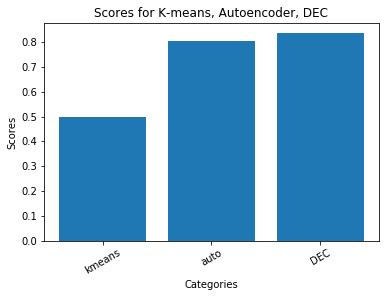

<Figure size 432x288 with 0 Axes>

In [37]:
# Need to plot the accuracies and save the results
# kmeans_score = 0.49
# auto_score = 0.8
# dec_score = 0.835




plt.bar([0,1,2], [kmeans_score, auto_score, dec_score])
plt.xticks([0,1,2], ['kmeans', 'auto', 'DEC'], rotation=30)
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title('Scores for K-means, Autoencoder, DEC')

plt.show()

savefig('scores_for_prototype.png')